### Import libraries

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import my_dlc_utils
import matplotlib.pyplot as plt
import seaborn as sns

### Set directory and read files

In [109]:
data_dir = "/Users/anacarolinabotturabarros/PycharmProjects/OPL/pose_files/20210308/"

files_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if
              (f.endswith(".csv"))]

# print(files_list)

In [110]:
subjects = {} # dictionary to hold dataframes for each subject
mouse_order = ['mA0','mB3','mB1','mB11']
for m_n, mouse in enumerate(files_list):
    subjects[mouse_order[m_n]] = pd.read_csv(mouse, header=[1,2], index_col=0)
    subjects[mouse_order[m_n]].name = mouse_order[m_n]
# examples on how to use the subjects dictionary (maybe want to change to a simple list - but it will depend on analysis)

subjects['mA0'].head() # prints top part of the dataframe
# subjects['mA0']['nose','x'] # call for a specific column
subjects['mA0'].columns.get_level_values(0).drop_duplicates() # get column names for the different indices

Index(['nose', 'left_ear', 'right_ear', 'tailbase', 'objectL', 'objectR'], dtype='object', name='bodyparts')

## Analysis

if it is a *no objects* session:

data to extract:
- trajectory (trace and heatmap)
- time in each half

if it has objects:
- trajectory (trace and heatmap)
- time in each half
- distance to objects / time within a certain distance


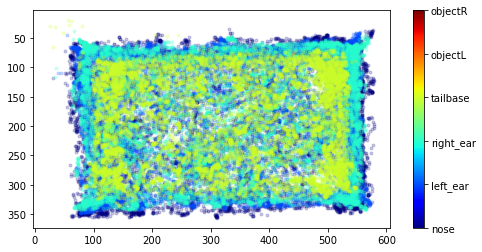

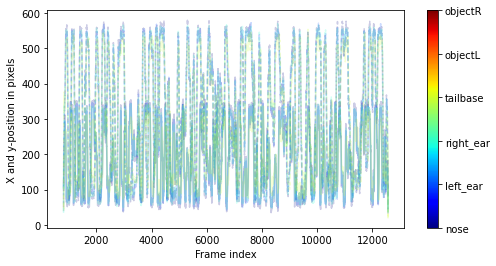

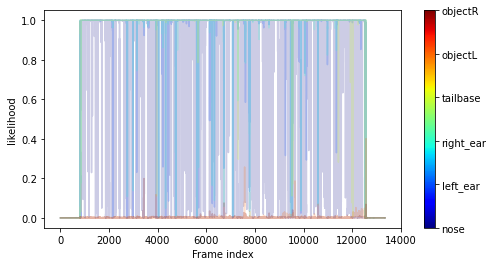

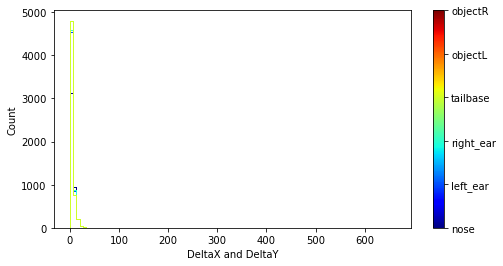

In [111]:
# for all files
# data to extract:
# - trajectory (trace and heatmap)
# - time in each half

Dataframe = subjects['mA0']
bps_to_plot=Dataframe.columns.get_level_values(0).drop_duplicates() #you can read out the header to get body part names!
#you could also take a subset, i.e. =['snout']

my_dlc_utils.PlottingResults(Dataframe,bps_to_plot,alphavalue=.2,pcutoff=.9,fs=(8,4))

In [112]:
# find objects position
objR = Dataframe['objectR'][Dataframe['objectR','likelihood'] > 0.9].mean()
objL = Dataframe['objectL'][Dataframe['objectL','likelihood'] > 0.9].mean()
objs = [objL, objR]
radius = 40 #temporary

def check_bp_in_circle(radius,center,bp_point):
    if (bp_point[0] - center[0])^2+(bp_point[1] - center[1])^2 <= radius^2:
        return True
    else:
        return False

# loop through session values for nose and check if they are inside the circle
# save this as an array of True and False which can be used as an index
# to know how many interactions --> how to save this
# to know how many frames had the nose close you can sum up the amount of frames
# write a function that counts interactions of a certain minimum time

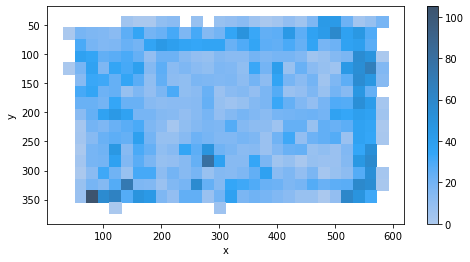

In [120]:
# plotting a heatmap
bp = 'nose'
ind = Dataframe[bp, 'likelihood'] > 0.9
f = plt.figure(figsize=(8,4))
ax = f.subplots()
sns.histplot(Dataframe[bp][ind],x='x', y='y', cbar=True, ax=ax, binwidth=(20, 20))
circle1 = plt.Circle((objs[0]['x'],objs[0]['y']) , 40, facecolor='none', edgecolor='r')
circle2 = plt.Circle((objs[1]['x'],objs[1]['y']) , 40, edgecolor='purple', facecolor='none')
circle11 = plt.Circle((objs[0]['x'],objs[0]['y']) , 4, color='r')
circle22 = plt.Circle((objs[1]['x'],objs[1]['y']) , 4, color='purple')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle11)
ax.add_patch(circle22)
ax.invert_yaxis()